In [1]:
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE2
  !ls

Mounted at /gdrive
/gdrive/MyDrive/University/ANN/CHALLENGE2
analysis.ipynb			 inno_training_smooth_7_ERR
baseline			 model.png
baseline_2			 multimodel_1
baseline_2_ckpt			 multimodel_2
baseline_3			 multi_model_2.ipynb
baseline_3_ckpt			 multi_model.ipynb
baseline_3_forSub		 multimodel_model.ipynb
baseline_3_training_smooth	 multimodel_with_baseline
baseline_3_training_smooth_ckpt  multimodel_with_baseline_2
baseline_4			 multimodel_with_baseline_3
baseline_4_ckpt			 my_net
baseline_5			 my_net_ckpt
baseline_5_ckpt			 my_net.ipynb
baseline_ckpt			 simple
baseline.ipynb			 simple_ckpt
d2ee2_ERR_smooth_training.ipynb  smooth_with_fft.ipynb
d2ee2_smooth_training.ipynb	 smooth_with_regression7.ipynb
err_7.csv			 smooth_with_regression.ipynb
inno_training_smooth		 Training.csv
inno_training_smooth_2		 Training_smooth2.csv
inno_training_smooth_3		 Training_smooth3.csv
inno_training_smooth_4		 Training_smooth4.csv
inno_training_smooth_4_1	 Training_smooth5.csv
inno_training_smooth_5		 Train

In [2]:
import pandas as pd
import numpy as np

In [3]:
dataset = pd.read_csv('./Training.csv')


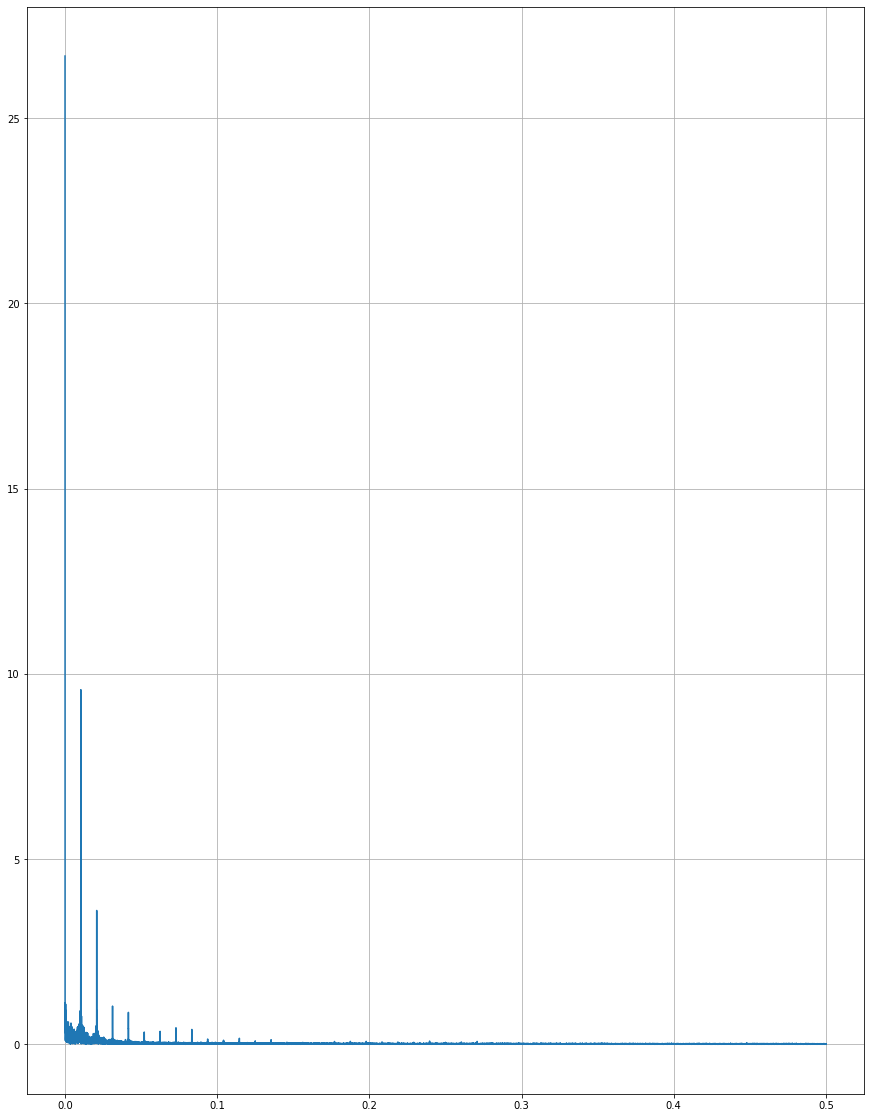

In [10]:
from scipy.fft import fft, ifft
from scipy.fftpack import fftfreq
import matplotlib.pyplot as plt
x = np.array(dataset['Crunchiness'])
N = len(x)
T = 1
time_step = 1
period = 1
yf = fft(x)

xf = fftfreq(N, T)[:N//2]

plt.figure(figsize=(15, 20))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))

plt.grid()
plt.show()

In [5]:
def visualize(x, r, inf=40, sup=400):
  discarded = len(x) - np.array(r).shape[0] 
  print("we discarded ", discarded, "initial points")
  x_ax = np.arange(sup - inf)
  plt.figure(figsize=(10, 6))
  plt.scatter(x_ax, x[inf + discarded:sup + discarded])
  plt.plot(x_ax, r[inf:sup], c='red')
  plt.show()

In [24]:
# Seed the random number generator
np.random.seed(1234)

time_step = 1

sig = np.array(dataset['Crunchiness'])
time_vec = np.arange(0, len(sig), time_step)


# plt.figure(figsize=(6, 5))
# plt.plot(time_vec, sig, label='Original signal')

In [26]:
def compute_fft(sig, time_step):
  # The FFT of the signal
  sig_fft = fft(sig)
  # The corresponding frequencies
  sample_freq = fftfreq(sig.size, d=time_step)
  return sig_fft, sample_freq

def compute_power(sig_fft):
  return np.abs(sig_fft)**2

def get_peak_freq(sig_fft, sample_freq, draw = False):
  # Find the peak frequency: we can focus on only the positive frequencies
  pos_mask = np.where(sample_freq > 0)
  freqs = sample_freq[pos_mask]
  power = compute_power(sig_fft)
  peak_freq = freqs[power[pos_mask].argmax()]
  if draw:
    # An inner plot to show the peak frequency
    axes = plt.axes([0.55, 0.3, 0.3, 0.5])
    plt.title('Peak frequency')
    plt.plot(freqs[:8], power[:8])
    plt.setp(axes, yticks=[])
  return peak_freq

In [50]:
sig_fft, sample_freq = compute_fft(sig, time_step)
power = compute_power(sig_fft)
peak_freq = get_peak_freq(sig_fft, sample_freq, False)

# # Plot the FFT power
# plt.figure(figsize=(10, 5))
# plt.plot(sample_freq, power)
# plt.xlabel('Frequency [Hz]')
# plt.ylabel('Power')


In [41]:
def get_k_peaks_height_and_ind(power, sample_freq, k, only_pos=False):
  m = [[0, 0] for i in range(k)]
  sample_f = sample_freq.copy()
  pow = power.copy()
  if only_pos:
    pos_mask = np.where(sample_f >= 0)
    sample_f = sample_f[pos_mask]
    pow = pow[pos_mask]

  for i, p in enumerate(pow):
    if p > m[0][0]:
      m[0][0] = p
      m[0][1] = i
      m.sort()
  return m

def get_k_freqs_sig(sig_fft, sample_freq, k):
  """
  get a signal whose fft is only the k highest peaks of sig_fft
  """
  power = compute_power(sig_fft)

  m = get_k_peaks_height_and_ind(power, sample_freq, k)
  # print(m)
  # print(len(power))
  s_f = [sample_freq[i[1]] for i in m]
  # print(s_f)

  int_freq = []
  inds = [i[1] for i in m]
  for i, s in enumerate(sig_fft):
    if i in inds:
      int_freq.append(s)
    else:
      int_freq.append(0)

  filtered_sig = ifft(int_freq)
  return filtered_sig

we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


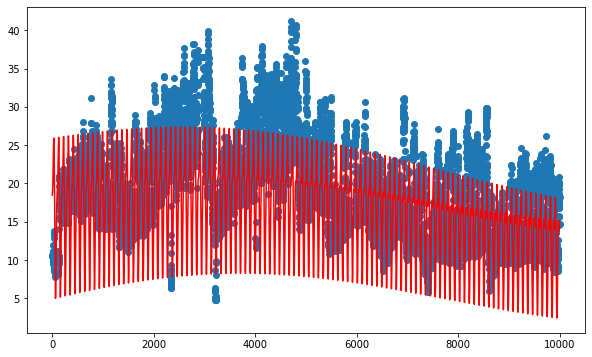

In [51]:
sig_fft, sample_freq = compute_fft(sig, time_step)
power = compute_power(sig_fft)
peak_freq = get_peak_freq(sig_fft, sample_freq, False)

k_freq_sig = get_k_freqs_sig(sig_fft, sample_freq, 10)
visualize(sig, k_freq_sig,0, 10000)

In [66]:
def get_without_high_freq_sig(sig_fft, sample_freq, k):
  """
  it will cut after the k-th peak
  """
  m = get_k_peaks_height_and_ind(power, sample_freq, k, True)
  peak_freq = sample_freq[m[-k][1]]
  print("cut at: ", peak_freq)

  high_freq_fft = sig_fft.copy()
  high_freq_fft[np.abs(sample_freq) > peak_freq] = 0
  filtered_sig = ifft(high_freq_fft)
  return filtered_sig

# plt.figure(figsize=(6, 5))
# plt.plot(time_vec, sig, label='Original signal')
# plt.plot(time_vec, filtered_sig, linewidth=3, label='Filtered signal')
# plt.xlabel('Time [s]')
# plt.ylabel('Amplitude')

# plt.legend(loc='best')


cut at:  0.010419098762549615
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


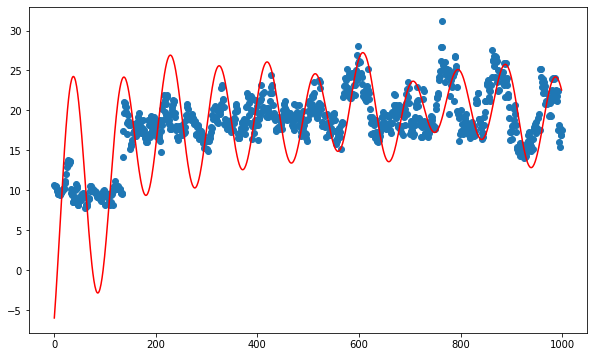

In [70]:
sig_fft, sample_freq = compute_fft(sig, time_step)
power = compute_power(sig_fft)
peak_freq = get_peak_freq(sig_fft, sample_freq, False)

without_high_freq = get_without_high_freq_sig(sig_fft, sample_freq, 2)
visualize(sig, without_high_freq,0, 1000)

In [74]:
def get_smoothed_without_high_freq_after_k_peak(x, k):
  sig_fft, sample_freq = compute_fft(x, time_step)
  power = compute_power(sig_fft)
  peak_freq = get_peak_freq(sig_fft, sample_freq, False)
  without_high_freq = get_without_high_freq_sig(sig_fft, sample_freq, k)
  return np.array(without_high_freq)

cut at:  0.010419098762549615
Sponginess done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


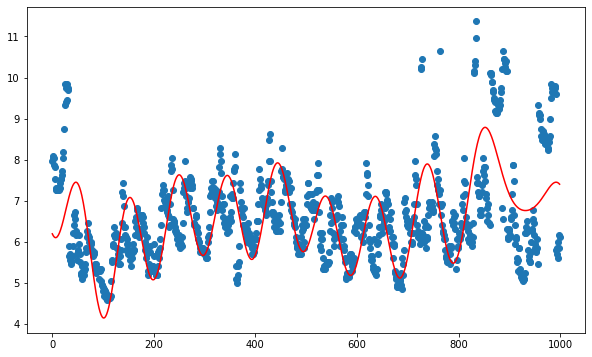

cut at:  0.010419098762549615
Wonder level done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


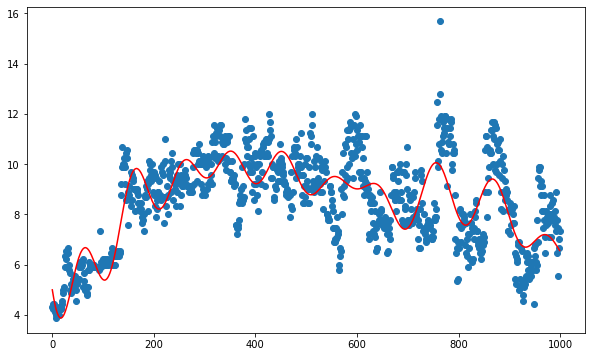

cut at:  0.010419098762549615
Crunchiness done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


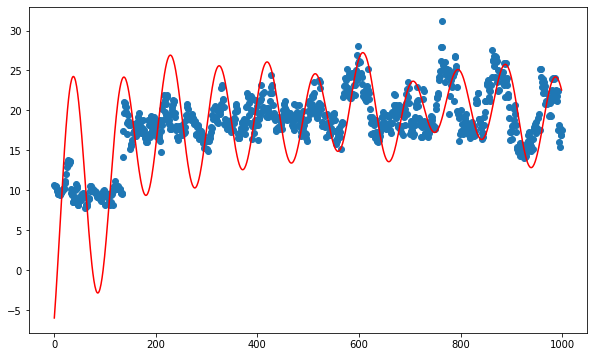

cut at:  0.010419098762549615
Loudness on impact done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


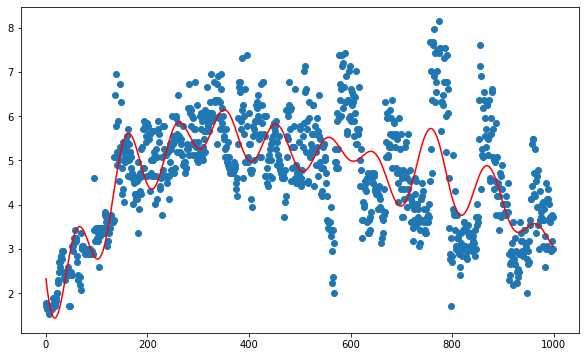

cut at:  0.010419098762549615
Meme creativity done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


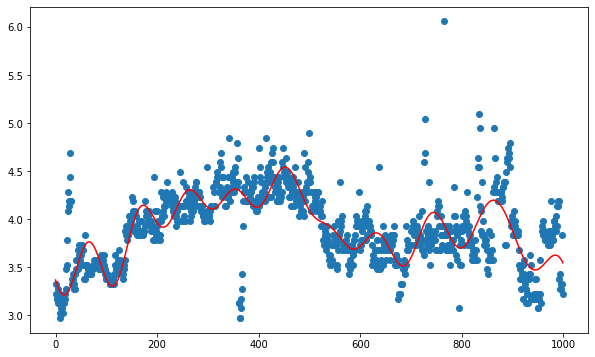

cut at:  0.010419098762549615
Soap slipperiness done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


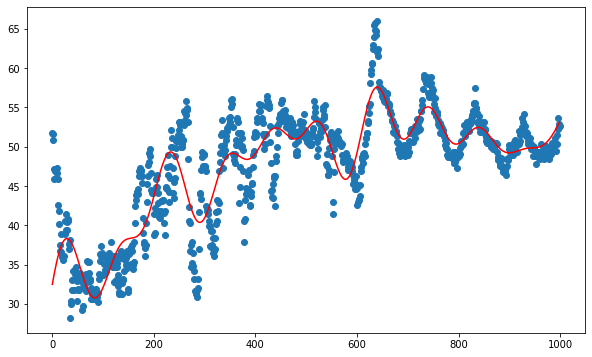

cut at:  0.010419098762549615
Hype root done
we discarded  0 initial points


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


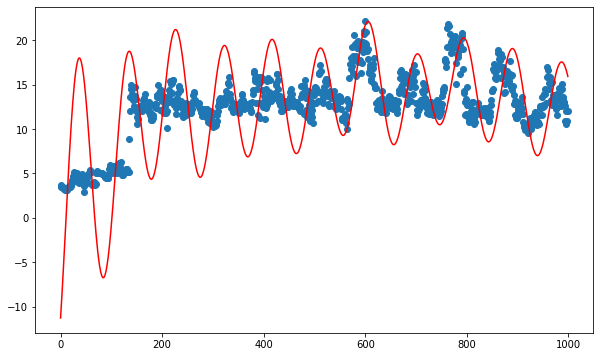

/usr/local/lib/python3.7/dist-packages/pandas/core/dtypes/cast.py:1625: ComplexWarning: Casting complex values to real discards the imaginary part
  subarr = np.array(values, dtype=dtype, copy=copy)


In [85]:
new = {}
for i in dataset:
  new[i] = get_smoothed_without_high_freq_after_k_peak(np.array(dataset[i]), 2)
  print(i, "done")
  visualize(dataset[i], new[i],0, 1000)
new = pd.DataFrame.from_dict(new, dtype=np.float64)

In [86]:
print(len(new['Sponginess']))
print(len(dataset['Sponginess']))

68528
68528


In [87]:
print(new['Crunchiness'])

0       -5.957676
1       -5.068712
2       -4.138377
3       -3.170377
4       -2.168549
           ...   
68523   -9.662930
68524   -9.030954
68525   -8.341487
68526   -7.597386
68527   -6.801704
Name: Crunchiness, Length: 68528, dtype: float64


In [88]:
save = True
if save:
  new.to_csv('Training_fft1.csv', index=False)